## Model Performance Benchmarks on GPU

Findings:

- There are performance gains after parallelizing the jobs on GPU.

- It seems like all the models somewhat respond well to the parallelization except dnn. Even with dnn, time_per_job doesn't go up all that much. 

- CNN responds to parallelization the best, MTCNN gains speed but not as much as CNN.

- DNN detects a face in every single image, MTCNN and CNN don't do as well. There are more stats on this in the next notebook.

In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import os
import glob

In [2]:
path = 'benchmarks_gpu/'

In [3]:
runtime_files = glob.glob(os.path.join(path, 'runtime*') )

In [4]:
def generate_dataframes(files, header=None):
    def read_file(file):
        fn = file.split('.')[0]
        df = pd.read_csv(file, header=header)
        df['name']=fn.split('/')[1]
        return df
    dfs = [read_file(file) for file in files]
    return dfs

In [5]:
dfs = generate_dataframes(runtime_files, 0)
runtime = pd.concat(dfs)

In [6]:
sp = runtime["name"].str.split("_", n = 2, expand = True) 
runtime['models'] = sp[1]
runtime['num_of_workers'] = sp[2]

In [7]:
det_proc_files = [x for x in glob.glob(os.path.join(path, '*')) if 'runtime' not in x and '*' not in x  ]

In [8]:
dfs = generate_dataframes(det_proc_files)
det_proc_times = pd.concat(dfs)
sp = det_proc_times['name'].str.split("_", n = 2, expand = True) 
det_proc_times['model'] = sp[1]
det_proc_times['num_of_workers'] = sp[2]
det_proc_times = det_proc_times.rename(columns={0: "proc_time", 1: "status"})

In [9]:
det_proc_times.groupby(['model', 'num_of_workers', 'status'])['proc_time'].mean().reset_index()

model num_of_workers   status  proc_time
0     cnn              1   failed   0.005847
1     cnn              1  success   0.024827
2     cnn              2   failed   0.015865
3     cnn              2  success   0.026515
4     cnn              3   failed   0.017193
5     cnn              3  success   0.046879
6     dnn              1  success   0.017032
7     dnn              2  success   0.033484
8     dnn              3  success   0.054306
9   mtcnn              1   failed   0.006357
10  mtcnn              1  success   0.030146
11  mtcnn              2   failed   0.025254
12  mtcnn              2  success   0.036728
13  mtcnn              3   failed   0.030606
14  mtcnn              3  success   0.065288

In [10]:
det_proc_times[det_proc_times['num_of_workers'] == '1'].groupby(['model', 'status'])['status'].count().reset_index(name='count')

model   status  count
0    cnn   failed     86
1    cnn  success     51
2    dnn  success    137
3  mtcnn   failed     80
4  mtcnn  success     57

In [11]:
det_runtime_files = [x for x in glob.glob(os.path.join(path, '*')) if 'runtime' in x and '*' not in x ]

In [12]:
dfs = generate_dataframes(det_runtime_files,0)
det_runtimes = pd.concat(dfs)
sp = det_runtimes['name'].str.split("_", n = 2, expand = True) 
det_runtimes['model'] = sp[1]
det_runtimes['num_of_workers'] = sp[2]

In [13]:
det_runtimes['num_of_workers'] = det_runtimes['num_of_workers'].astype('int32') 


- avg_det_time is calculated by sum(detection processing time)/total number of jobs

- avg_rec_time is calculated by sum(recognition processing time)/total number of jobs

- tot_time is the total runtime of the program

- time_per_job is the total runtime divided by the total number of jobs


the average detection and recognition times will be higher than the time_per_job as they are being run in parallel and can take slightly higher in parallel setting which doesn't indicate anything bad. What we care about is the total runtime and the time_per_job (the same calculation Sondre did the posenet gpu stress test).

model is the name of the model run, the table below is the results for detection only, that's why the avg_rec_time is 0

In [14]:
det_runtimes.sort_values(by=['time_per_job'])

avg_det_time  avg_rec_time  tot_time  time_per_job  num_of_jobs  \
0      0.017451           0.0  1.342178      0.009797          137   
0      0.009870           0.0  1.391873      0.010160          137   
0      0.009242           0.0  1.787093      0.013044          137   
0      0.027163           0.0  2.074784      0.015144          137   
0      0.015281           0.0  2.076356      0.015156          137   
0      0.012542           0.0  2.250735      0.016429          137   
0      0.017032           0.0  2.372588      0.017318          137   
0      0.033484           0.0  2.394559      0.017479          137   
0      0.054306           0.0  2.587156      0.018884          137   

              name  model  num_of_workers  
0    runtime_cnn_3    cnn               3  
0    runtime_cnn_2    cnn               2  
0    runtime_cnn_1    cnn               1  
0  runtime_mtcnn_3  mtcnn               3  
0  runtime_mtcnn_2  mtcnn               2  
0  runtime_mtcnn_1  mtcnn               1  
0    runtime_dnn_1    dnn               1  
0    runtime_dnn_2    dnn               2  
0    runtime_dnn_3    dnn               3

In [15]:
models = det_runtimes['model'].unique()
dfs = []
for model in models:
    dt = det_runtimes[det_runtimes['model'] == model]
    dfs.append(dt)

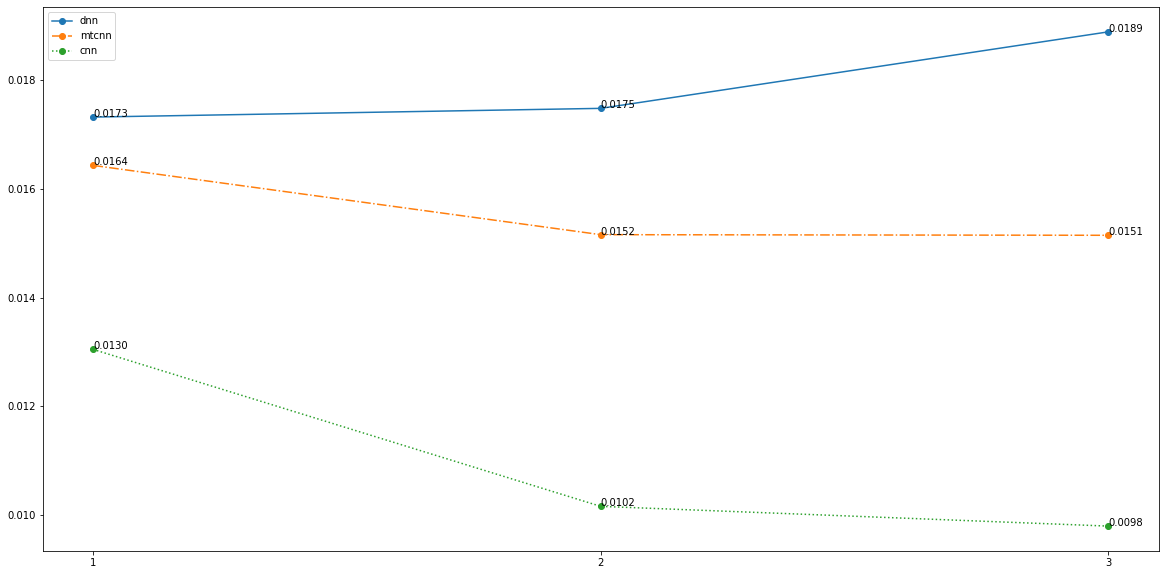

In [16]:
plt.figure(figsize=(20,10))
dots = ['o-', 'o-.', 'o:']
for i, df in enumerate(dfs):
    x = df['num_of_workers']
    y = df['time_per_job']
    plt.plot(x, y, dots[i], label=df.model.values[0])
    for i,j in zip(df['num_of_workers'],df['time_per_job']):
        plt.annotate("%.4f" %j,xy=(i,j))
plt.legend(loc='best')
plt.xticks([1,2,3])
plt.show()

In [ ]:
runtime_det_rec = runtime[runtime['models'].apply(lambda x:'*' in x)]
sp = runtime_det_rec['num_of_workers'].str.split("_", n = 1, expand = True) 
runtime_det_rec['dw'] = sp[0]
runtime_det_rec['rw'] = sp[1]
runtime_det_rec = runtime_det_rec.drop(columns=['name'])


- dw -> detection workers

- rw -> recognition workers

In [25]:
runtime_det_rec[['avg_det_time', 'avg_rec_time', 'time_per_job', 'models', 'dw', 'rw']].sort_values(by=['time_per_job'])

avg_det_time  avg_rec_time  time_per_job          models dw rw
0      0.018115      0.008466      0.011090    cnn*openface  3  2
0      0.026461      0.008593      0.011344    cnn*openface  4  2
0      0.010133      0.008278      0.011564    cnn*openface  2  2
0      0.025118      0.005120      0.011725    cnn*openface  4  1
0      0.017472      0.005216      0.011997    cnn*openface  3  1
0      0.010042      0.005349      0.012100    cnn*openface  2  1
0      0.032951      0.005618      0.012425    cnn*openface  5  1
0      0.009566      0.005570      0.013850    cnn*openface  1  1
0      0.026187      0.008549      0.015259     cnn*facenet  4  1
0      0.017722      0.008834      0.015309     cnn*facenet  3  1
0      0.010588      0.009079      0.015412     cnn*facenet  2  1
0      0.029687      0.009035      0.015635     cnn*facenet  5  1
0      0.016491      0.005093      0.016372  mtcnn*openface  2  2
0      0.029392      0.006036      0.016587  mtcnn*openface  3  2
0      0.009720      0.010287      0.016621     cnn*facenet  1  1
0      0.016742      0.004823      0.016652  mtcnn*openface  2  1
0      0.029792      0.005403      0.016934  mtcnn*openface  3  1
0      0.013122      0.004032      0.017790  mtcnn*openface  1  1
0      0.037533      0.006916      0.018343  mtcnn*openface  4  2
0      0.050245      0.006764      0.018621  mtcnn*openface  5  1
0      0.057120      0.014049      0.019943    dnn*openface  3  2
0      0.038655      0.012506      0.019973    dnn*openface  2  1
0      0.038491      0.012360      0.020024    dnn*openface  2  2
0      0.020115      0.010809      0.020448    dnn*openface  1  1
0      0.020655      0.010155      0.020852   mtcnn*facenet  2  1
0      0.059750      0.013357      0.020975    dnn*openface  3  1
0      0.033584      0.010730      0.021312   mtcnn*facenet  3  1
0      0.015134      0.008677      0.021524   mtcnn*facenet  1  1
0      0.083153      0.014814      0.021800    dnn*openface  4  2
0      0.084023      0.015356      0.022134    dnn*openface  4  1
0      0.041127      0.011421      0.022228   mtcnn*facenet  4  1
0      0.103059      0.017722      0.022478    dnn*openface  5  1
0      0.022298      0.019716      0.022677     dnn*facenet  1  1
0      0.065467      0.032920      0.022925     dnn*facenet  3  2
0      0.041153      0.021615      0.022989     dnn*facenet  2  1
0      0.044516      0.030525      0.023104     dnn*facenet  2  2
0      0.056958      0.011908      0.023364   mtcnn*facenet  5  1
0      0.094363      0.032962      0.024691     dnn*facenet  4  2
0      0.065104      0.023574      0.025256     dnn*facenet  3  1
0      0.085510      0.023622      0.025894     dnn*facenet  4  1
0      0.106906      0.024986      0.027337     dnn*facenet  5  1

In [20]:
models = runtime_det_rec['models'].unique()
dfs = []
for model in models:
    dt = runtime_det_rec[runtime_det_rec['models'] == model].sort_values(by=['num_of_workers'])
    dfs.append(dt)

Below is the table for different pairings of detection and recognition models and their performances with num_of_workers. 

- num_of_worker = [detection_workers]_[recognition_workers]

If a dot missing from the table, that means, it ran out of memory and it is excluded. The points below are all successful runs.

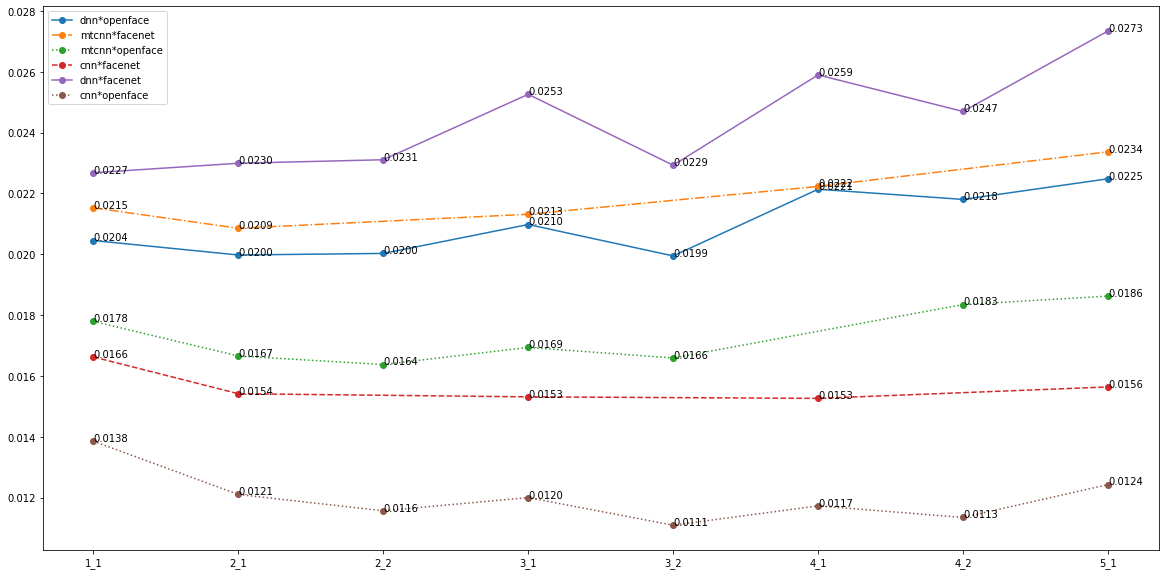

In [21]:
plt.figure(figsize=(20,10))
dots = ['o-', 'o-.', 'o:', 'o--', 'o-', 'o:']
for i, df in enumerate(dfs):
    x = df['num_of_workers']
    y = df['time_per_job']
    plt.plot(x, y, dots[i], label=df.models.values[0])
    for i,j in zip(df['num_of_workers'],df['time_per_job']):
        plt.annotate("%.4f" %j,xy=(i,j))
plt.legend(loc='best')
plt.show()